# Simulating Correlational Data - Introduction to RCTs
[J. Nathan Matias](https://natematias.com), Feb 6, 2019

This notebook is part of [SOC412, Designing Field Experiments at Scale](https://natematias.com/courses/soc412/syllabus.html)

Data is drawn from [a Poetryfoundation dataset](https://github.com/jacobbridges/poetry-collection-api) scraped by Jacob Bridges and made available on Github.

In [285]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(gmodels) #includes CrossTable
library(tidyverse)
library(gender)
## to install the genderdata package, run the following command:
## install.packages("genderdata", repos = "http://packages.ropensci.org", type = "source")
library(genderdata)
library(viridis)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

library(jsonlite)

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)

# Load Poetry Dataframe

In [286]:
poems <- fromJSON(paste(readLines("data/poetryfoundation.org-scrape-08-15-2015.json"), collapse=""))

Warning message in readLines("data/poetryfoundation.org-scrape-08-15-2015.json"):
“incomplete final line found on 'data/poetryfoundation.org-scrape-08-15-2015.json'”

In [340]:
print(paste("Loaded ", nrow(poems), 
            " poems from the poetry foundation database. Each row has the following columns:"))
poems$length <- nchar(trimws(poems$text))
print(colnames(poems))

[1] "Loaded  12959  poems from the poetry foundation database. Each row has the following columns:"
 [1] "reference"      "classification" "title"          "text"          
 [5] "region"         "author"         "period"         "year"          
 [9] "keywords"       "length"         "color"          "fname"         
[13] "sim.year"      


### Set Random Seed

In [341]:
set.seed(1549507241)

### Create Color Background Cutoff
Imagine for example that Facebook allowed color backgrounds for poems that were less than 500 characters long (it's actually ~ 130 characters). Here I assign that cutoff.

In [348]:
poems$color <- poems$length < 1000

### Create Estimated Name Sex Field and Omit Non-Matches
In real life, you would never want to do this, but this is a
simulated dataset for assignment purposes

In [349]:
poems$fname <- sapply(strsplit(poems$author, " "), `[`, 1)
poems[is.na(poems$fname)==TRUE,]$fname="NA"
poems[nchar(poems$fname)<3,]$fname="NA"
poems$sim.year <- 2000

In [350]:
unique.name.sex <- gender_df(poems, name_col="fname", year_col="sim.year", method="ssa")
unique.name.sex$fname <- unique.name.sex$name

In [351]:
all.poems <- merge(x=poems, y=unique.name.sex, by="fname")[c("author", "title", "length", "gender", "color")]
all.poems$name.sex <- all.poems$gender
all.poems$gender <- NULL

### Create Facebook Interaction Simulation

In [292]:
all.poems$sim.base.interactions <- rnegbin(nrow(all.poems), mu=200, theta=4.5)
all.poems$sim.interactions <- as.integer(all.poems$sim.base.interactions * 1/log1p(all.poems$length))

### Generate Summary Information for the Slides

In [293]:
head(all.poems[c("author", "title", "sim.interactions",  "length",  "name.sex", "color")], 15)

author,title,sim.interactions,length,name.sex,color
Aaron Shurin,The Bride of Frank,100,12,male,TRUE
Aaron Shurin,Plume,32,856,male,TRUE
Aaron Poochigian,The Vigil,34,147,male,TRUE
Aaron Shurin,Cool Dust,12,1082,male,FALSE
Aaron Shurin,Then,39,1552,male,FALSE
Abid B Al-Abras,Last Simile,13,554,male,TRUE
Abigail Deutsch,Twenty-Two,60,803,female,TRUE
Abigail Deutsch,After the Disaster,25,814,female,TRUE
Abraham Cowley,Platonic Love,17,1077,male,FALSE
Abraham Lincoln,To Rosa,50,277,male,TRUE


In [295]:
## SHOW THE DIFFERENCE IN MEANS
aggregate(sim.interactions ~ color,
          data=all.poems, mean)

color,sim.interactions
FALSE,25.75
TRUE,33.76


In [296]:
## CONDUCT A T-TEST BETWEEN COLOR AND PLAIN
print(t.test(all.poems$sim.interactions ~ all.poems$color))


	Welch Two Sample t-test

data:  all.poems$sim.interactions by all.poems$color
t = -26, df = 11000, p-value <2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.621 -7.393
sample estimates:
mean in group FALSE  mean in group TRUE 
              25.75               33.76 



In [314]:
## SHOW THE DIFFERENCE IN MEANS BETWEEN DIFFERENT NAME SEXES
print(cor.test(all.poems$sim.interactions, 
               all.poems$length, method="pearson"))


	Pearson's product-moment correlation

data:  all.poems$sim.interactions and all.poems$length
t = -17, df = 12000, p-value <2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1733 -0.1381
sample estimates:
    cor 
-0.1557 



In [325]:
## LINEAR REGRESSION MODEL
summary(lm(sim.interactions ~ color + length, data=all.poems))


Call:
lm(formula = sim.interactions ~ color + length, data = all.poems)

Residuals:
   Min     1Q Median     3Q    Max 
 -31.8  -11.5   -2.9    7.4  368.9 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 27.2389765  0.2952519   92.26   <2e-16 ***
colorTRUE    6.8296952  0.3535540   19.32   <2e-16 ***
length      -0.0005364  0.0000597   -8.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.7 on 11785 degrees of freedom
Multiple R-squared:  0.0542,	Adjusted R-squared:  0.054 
F-statistic:  338 on 2 and 11785 DF,  p-value: <2e-16


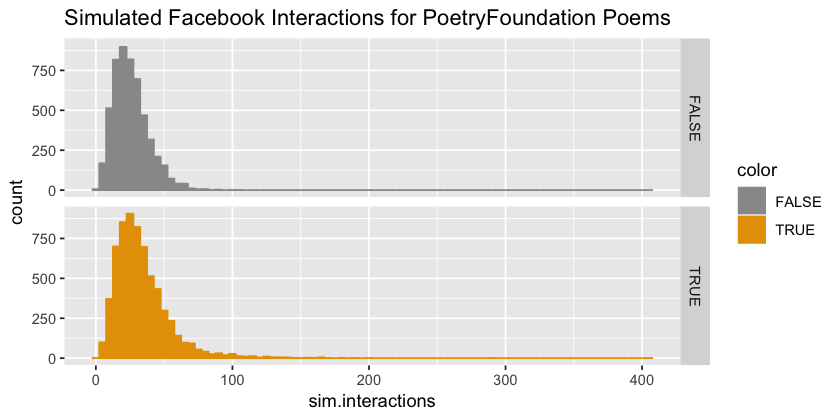

In [327]:
ggplot(all.poems, aes(sim.interactions, color=color, fill=color))  +
    facet_grid(color ~ .) +
    scale_fill_manual(values=cbPalette) +
    scale_color_manual(values=cbPalette) +
    geom_histogram(binwidth=5) +
    ggtitle("Simulated Facebook Interactions for PoetryFoundation Poems")

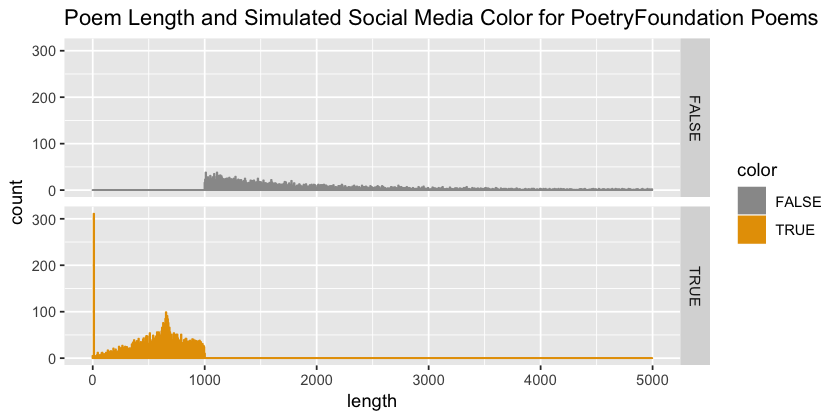

In [355]:
ggplot(subset(all.poems, length < 5000), aes(length, color=color, fill=color))  +
    facet_grid(color ~ .) +
    scale_fill_manual(values=cbPalette) +
    scale_color_manual(values=cbPalette) +
    geom_histogram(binwidth=5) +
    ggtitle("Poem Length and Simulated Social Media Color for PoetryFoundation Poems")

# Software Environment
This example was generated using the following R configurations and libraries.

In [4]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.13.0 estimatr_0.14        fabricatr_0.6.0     
 [4] randomizr_0.16.1     viridis_0.5.1        viridisLite_0.3.0   
 [7] forcats_0.3.0        stringr_1.3.1        purrr_0.2.5         
[10] readr_1.3.1          tidyr_0.8.2          tibble_2.0.0        
[13] tidyverse_1.2.1      rlang_0.3.0.1        ggplot2_3.1.0       
[16] MASS_7.3-51.1        dplyr_0.7.8         

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_0.19.1      haven_2.0.0     


# You are Free to Copy & Reuse this Code¶ 
Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.